In [1]:
import Model
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from tensorflow.keras.models import Model
from tqdm import tqdm 
import time
import os
import re
import hashlib
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import SpeechGenerator
import librosa
#from keras import losses

from extractMFCC import computeFeatures, computeFeatures1
from addNoise import addNoise

tf.enable_eager_execution()
print(tf.executing_eagerly())
print(tf.__version__)
print(tf.keras.__version__)

Using TensorFlow backend.


True
1.14.0
2.2.4-tf


In [2]:
# Root folder of the dataset
dataset_dir = "Dataset/"

In [3]:
# File containing the path that identify the test and validation set
testWAVs = pd.read_csv(dataset_dir + 'testing_list.txt', sep=" ", header = None)[0].tolist()
valWAVs  = pd.read_csv(dataset_dir + 'validation_list.txt', sep=" ", header = None)[0].tolist()

In [4]:
# Dictionary containing the mapping between category name and label
DictCategs = {'nine' : 1, 'yes' : 2, 'no' : 3, 'up' : 4, 'down' : 5, 'left' : 6, 'right' : 7, 'on' : 8, 'off' : 9, 
              'stop' : 10, 'go' : 11, 'zero' : 12, 'one' : 13, 'two' : 14, 'three' : 15, 'four' : 16, 'five' : 17, 
              'six' : 18, 'seven' : 19, 'eight' : 20, 'backward':0, 'bed':0, 'bird':0, 'cat':0, 'dog':0, 'follow':0, 
              'forward':0, 'happy':0, 'house':0, 'learn':0, 'marvin':0, 'sheila':0, 'tree':0, 'visual':0, 'wow':0 }
nCategs = 21

In [5]:
# Load all the file in dataset
allWAVs  = []
for root, dirs, files in os.walk('Dataset/'):
    for f in files:
        if (root != dataset_dir + "_background_noise_") and (f.endswith('.wav')):
            path = root + "/" + f
            #print(path)
            path = path[len(dataset_dir):]
            #print(path)
            allWAVs.append(path)

# Remove from the training set the elements present in test and validation
trainWAVs = list(set(allWAVs) - set(valWAVs) - set(testWAVs))

In [6]:
# Size of sets
print("Train set length: " + str(len(trainWAVs)))
print("Validation set length: " + str(len(valWAVs)))
print("Test set length: " + str(len(testWAVs)))

Train set length: 84843
Validation set length: 9981
Test set length: 11005


In [7]:
# Function to extract the category from the path to the file
def _getFileCategory(file, catDict):
    # Receives a file with name <cat>/<filename> and returns an integer that is catDict[cat]
    categ = os.path.basename(os.path.dirname(file))
    return catDict.get(categ, 0)

In [8]:
# Get categories of each set
testWAVlabels = [_getFileCategory(f, DictCategs) for f in testWAVs]
valWAVlabels = [_getFileCategory(f, DictCategs) for f in valWAVs]
trainWAVlabels = [_getFileCategory(f, DictCategs) for f in trainWAVs]

# And test the size of the labels set
print("Train-Labels set length: " + str(len(trainWAVlabels)))
print("Validation-Labels set length: " + str(len(valWAVlabels)))
print("Test-Labels set length: " + str(len(testWAVlabels)))

Train-Labels set length: 84843
Validation-Labels set length: 9981
Test-Labels set length: 11005


In [9]:
# Transoform the train dataset in numpy array and load them 
train = np.array(trainWAVs, dtype = object)
trainLabels = np.array(trainWAVlabels, dtype = '>i4') #stands for int32

print("Loading of the train set:")
for i in range(len(trainWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(trainWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + trainWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + trainWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + trainWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    train[i] = trainWAVs[i] + '.npy'
    
print(str(i+1) + '/' + str(len(trainWAVs)))

Loading of the train set:
0/84843
5000/84843
10000/84843
15000/84843
20000/84843
25000/84843
30000/84843
35000/84843
40000/84843
45000/84843
50000/84843
55000/84843
60000/84843
65000/84843
70000/84843
75000/84843
80000/84843
84843/84843


In [10]:
# Do the same thing for the validation and the test set
val = np.array(valWAVs, dtype = object)
valLabels = np.array(valWAVlabels, dtype = '>i4') #stands for int32

print("Loading of the validation set:")
for i in range(len(valWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(valWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + valWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + valWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + valWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    val[i] = valWAVs[i] + '.npy'
    
print(str(i+1) + '/' + str(len(valWAVs)))

test = np.array(testWAVs, dtype = object)

print("Loading of the test set:")
for i in range(len(testWAVs)):
    # Print the progress 
    if (i % 5000) == 0:
        print(str(i) + '/' + str(len(testWAVs)))
    
    # If the file is not already present, we create the numpy version 
    if (not os.path.isfile(dataset_dir + "/" + testWAVs[i] + '.npy')):
        y, sr = librosa.load(dataset_dir + "/" + testWAVs[i], sr = 16000)
        np.save(dataset_dir + "/" + testWAVs[i] + '.npy', y)
    
    # We load the path to numpy array in a vector 
    test[i] = testWAVs[i] + '.npy' 
    
print(str(i+1) + '/' + str(len(testWAVs)))

Loading of the validation set:
0/9981
5000/9981
9981/9981
Loading of the test set:
0/11005
5000/11005
10000/11005
11005/11005


In [11]:
#test on the length
print(str(len(trainWAVs)) + " = " + str(len(train)))
print(str(len(valWAVs)) + " = " + str(len(val)))
print(str(len(testWAVs)) + " = " + str(len(test)))

#test on labels 
for i in range(0, 1):
    print("file: " + train[i] + " - label: " + str(trainLabels[i]))
    print("file: " + trainWAVs[i] + " - label: " + str(trainLabels[i]))

84843 = 84843
9981 = 9981
11005 = 11005
file: bed/4c594e0f_nohash_0.wav.npy - label: 0
file: bed/4c594e0f_nohash_0.wav - label: 0


Text(0.5, 1.0, 'WAV signal')

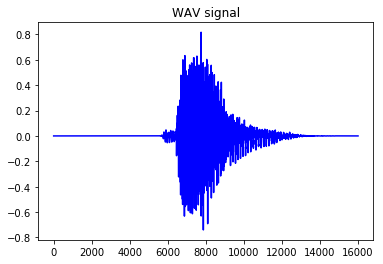

In [12]:
# Function to load numpy array
def load_data(file_name, data_dir):
    # Load the wav signal from the .npy file
    data = np.load(data_dir + file_name)
    return data

# Plot a wav
file_name = train[25]
data = load_data(file_name, dataset_dir)
plt.figure()
plt.plot(data, color='b')
plt.title('WAV signal')

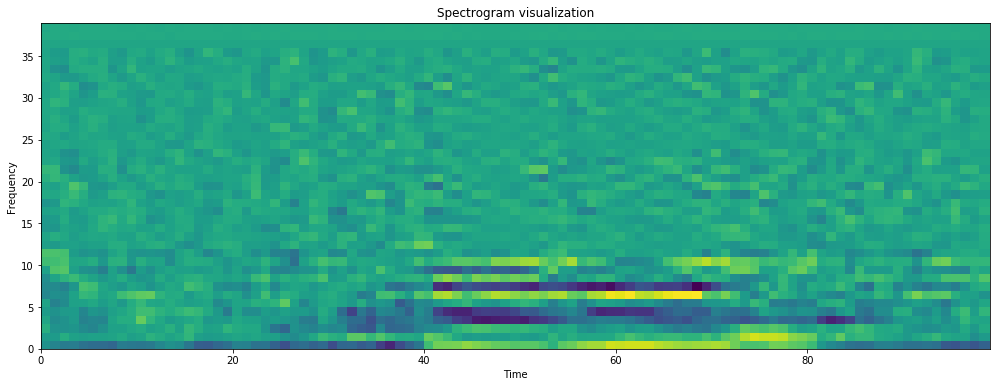

File: forward/a55105d0_nohash_4.wav.npy - Label: 0


In [13]:
# Function to preprocess the data 
def load_and_preprocess_data(file_name, data_dir):
    # Required by tensorflow (strings are passed as bytes)
    if type(file_name) is bytes:
        file_name = file_name.decode()
        data_dir = data_dir.decode()

    # Load data
    data = load_data(file_name, data_dir)
    feats = computeFeatures1(data, 16000)
    # Normalize
    #feats -= (np.mean(feats, axis=0) + 1e-8)
    #mean = np.mean(feats, axis = 0)
    #stv = np.std(feats, axis = 0)
    #diff = np.subtract(feats, mean)
    #feats = np.divide(diff, stv)

    return feats.astype(np.float32)

# example:
index = 26257
feats = load_and_preprocess_data(train[index], dataset_dir)
feats = np.transpose(feats)
#plt.plot(feats, color='b')
plt.figure(figsize=(17,6))
plt.pcolormesh(feats)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()
print("File: " + train[index] + " - Label: " + str(trainLabels[index]))
#print(np.max(feats))

In [14]:
def create_dataset(data_dir, file_names, labels, batch_size = 32, shuffle = True, cache_file = None):
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    
    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.py_func(load_and_preprocess_data, [file_name, data_dir], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls = os.cpu_count())
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
    
    # Shuffle    
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        
    # Repeat the dataset indefinitely (capire bene anche questo repeat come funziona)
    #dataset = dataset.repeat()
    
    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, -1), label))
    
    # Batch
    dataset = dataset.batch(batch_size = batch_size)
    
    # Prefetch (TODO: da cambiare questo e capire come funziona)
    dataset = dataset.prefetch(buffer_size = 1)
    
    return dataset


In [15]:
batch_size = 32

train_dataset = create_dataset(dataset_dir, train, trainLabels, batch_size = batch_size, shuffle = True, cache_file = 'train_cache')

val_dataset = create_dataset(dataset_dir, val, valLabels, batch_size = batch_size, shuffle = False, cache_file = 'val_cache')

train_steps = int(np.ceil(len(train) / batch_size))
val_steps = int(np.ceil(len(val) / batch_size))
print("steps per completare un epoca di train: " + str(train_steps))
print("steps per completare un epoca di validation: " + str(val_steps))

W0628 16:28:32.964558 139623002822400 deprecation.py:323] From <ipython-input-14-3369a57ef390>:7: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


2652
312


In [17]:
""" Questa parte con la eager execution attiva non va, ma non è un problema
# Initialize a dataset for test
small_dataset = create_dataset(dataset_dir,
                               train[:100], 
                               trainLabels[:100], 
                               batch_size = batch_size, 
                               shuffle = True, 
                               cache_file = 'small_cache')

# Define an iterator to get data
iterator = small_dataset.make_one_shot_iterator()
next_element = iterator.get_next()
# Start a new session
with tf.Session() as sess:
    # Iterate for 3 epochs
    for num_epoch in range(3):
        # Time the loading time
        it = time.time()
        for step in tqdm(range(3)):
                # Get the next batch of data
                data, label = sess.run(next_element)
        # Print loading time
        print('EPOCH {} - Time to load the entire dataset [seconds]: {}'.format(num_epoch+1, time.time() - it))
    
# Remove the created cache
os.remove('small_cache.data-00000-of-00001')
os.remove('small_cache.index')
"""

W0628 16:28:43.916669 139623002822400 deprecation.py:323] From <ipython-input-17-8e4813be7eb7>:10: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
  0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

In [ ]:
#trainGen = SpeechGenerator.SpeechGen(train, trainLabels, dataset_dir, batch_size = 64, shuffle = True)
#valGen = SpeechGenerator.SpeechGen(val, valLabels, dataset_dir, batch_size = 16, shuffle = False)    

In [16]:
#keras.backend.set_floatx('float32')

#print(keras.backend.floatx())

model = Model.SimpleModel(nCategs, 99, 39, use_GRU = True, dropout = 0.1, activation = 'relu')
"""
decayed_lr = tf.train.exponential_decay(0.0000001,
                                        0.8, 50,
                                        0.95, staircase=True)

adam = tf.train.AdamOptimizer(learning_rate=decayed_lr,  
                                beta1=0.9,
                                beta2=0.999,
                                epsilon=1e-07,
                                use_locking=False,
                                name='Adam')
"""
adam = tf.train.AdamOptimizer(learning_rate=0.001,  
                                beta1=0.9,
                                beta2=0.999,
                                epsilon=1e-07,
                                use_locking=False,
                                name='Adam')

#model.compile(optimizer=adam,
#              loss= tf.losses.softmax_cross_entropy,
#              metrics=[keras.metrics.sparse_categorical_accuracy, ])

#model.compile(optimizer = adam,
#              loss = tf.keras.losses.sparse_categorical_crossentropy,
#              metrics = ['sparse_categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 99, 39, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 95, 35, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 11, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 11, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 9, 32)         18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 3, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 3, 32)          128   

In [20]:
#Try manual learining 

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Iterate over epochs.
for epoch in range(10):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
            
            print("inside the tape")

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        # Update training metric.
        train_acc_metric(y_batch_train, logits)

        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))
        
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
""" Questa parte si puo scommentare dovebbe usare il validation set e basta 
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print('Validation acc: %s' % (float(val_acc),))
"""

Start of epoch 0
inside the tape
Training loss (for one batch) at step 0: 2.923954963684082
Seen so far: 64 samples
inside the tape
Training loss (for one batch) at step 1: 3.8171277046203613
Seen so far: 128 samples
inside the tape
Training loss (for one batch) at step 2: 3.401384115219116
Seen so far: 192 samples
inside the tape
Training loss (for one batch) at step 3: 3.0038671493530273
Seen so far: 256 samples
inside the tape
Training loss (for one batch) at step 4: 2.8590378761291504
Seen so far: 320 samples
inside the tape
Training loss (for one batch) at step 5: 2.986589193344116
Seen so far: 384 samples
inside the tape
Training loss (for one batch) at step 6: 2.826308012008667
Seen so far: 448 samples
inside the tape
Training loss (for one batch) at step 7: 2.6467840671539307
Seen so far: 512 samples
inside the tape
Training loss (for one batch) at step 8: 2.9938552379608154
Seen so far: 576 samples
inside the tape
Training loss (for one batch) at step 9: 2.616656541824341
Seen

"\n    # Run a validation loop at the end of each epoch.\n    for x_batch_val, y_batch_val in val_dataset:\n        val_logits = model(x_batch_val)\n        # Update val metrics\n        val_acc_metric(y_batch_val, val_logits)\n\n    val_acc = val_acc_metric.result()\n    val_acc_metric.reset_states()\n    print('Validation acc: %s' % (float(val_acc),))\n"

In [21]:
# Save the model (ho aggiornato il modello, se vuoi salvare cambia il numero)
model.save('Model/my_model_using-tf-lowlevel-api-2.h5')

In [26]:
test_dataset = create_dataset(dataset_dir, test, testWAVlabels, batch_size = 1, shuffle = False, cache_file = 'test_cache')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

testEval = model.evaluate(test_dataset, verbose = 1)

11005/11005 [==============================] - 356s 32ms/step - loss: 0.9338 - sparse_categorical_accuracy: 0.7042


In [ ]:
""" CApire se con eager execution attiva funziona il fit normale, che sarebbe molto meglio
adam = tf.train.AdamOptimizer(learning_rate=0.001,  
                                beta1=0.9,
                                beta2=0.999,
                                epsilon=1e-07,
                                use_locking=False,
                                name='Adam')

model.compile(optimizer = adam,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['sparse_categorical_accuracy'])

num_epochs = 10
history = model.fit(train_dataset, 
                    epochs = num_epochs, 
                    #steps_per_epoch = train_steps,
                    validation_data = val_dataset, 
                    validation_steps = val_steps)

# Save the model
model.save('Model/my_model_using-tf.h5')

print(history.history.keys())

# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='Train acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val acc')
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
"""

In [ ]:
""" DA capire come usare questa cosa che può essere molto utile
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

earlystopper = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=1)
checkpointer = ModelCheckpoint('Model/my_model_loss_dropout-0_05-yes_reg-0.h5', 
                               monitor='val_categorical_accuracy', 
                               verbose=1, save_best_only = True, save_weights_only = True)
"""

In [34]:
# I don't now why i need to reshape in this way but it works 
x = "tree/022cd682_nohash_1.wav.npy"
x = load_and_preprocess_data(x, dataset_dir).reshape((1, 99, 39, 1))
print(x.shape)
res = model.predict(x) 
print(res.argmax())

(1, 99, 39, 1)
0
